In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from sklearn.neighbors import NearestNeighbors
import scipy as sp
from scipy.spatial import distance
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_scatter_density 
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/M67-result.csv')

In [3]:
df.columns

Index(['source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'pmra', 'pmdec', 'phot_g_mean_mag', 'bp_rp', 'bp_g',
       'g_rp', 'radial_velocity', 'radial_velocity_error',
       'phot_variable_flag', 'l', 'b', 'teff_val', 'a_g_val', 'r_est', 'r_lo',
       'r_hi', 'r_len'],
      dtype='object')

In [4]:
df = df[df['parallax'] > 0]
df = df[df['phot_g_mean_mag'] < 18]

## Functions

In [5]:
def cmd_plot(data, x_axis, y_axis, alpha=0.8, s=5):
    with plt.style.context(['ieee']):
        fig = plt.figure(figsize=(6,6), dpi=100)
        sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s)
        plt.gca().invert_yaxis();

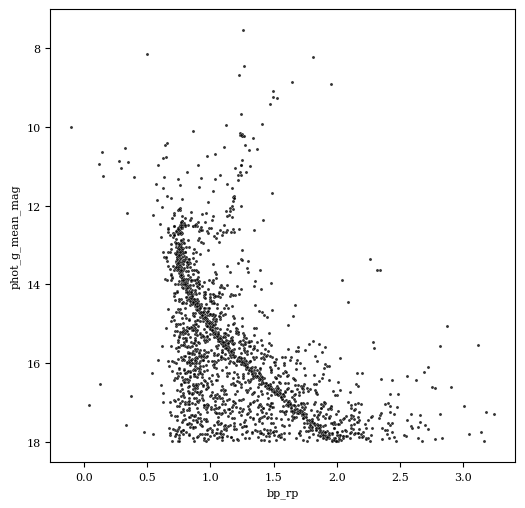

In [6]:
cmd_plot(df, 'bp_rp', 'phot_g_mean_mag')

Absolute Magnitude

In [7]:
df['Gmg'] = df['phot_g_mean_mag'] + (5 * np.log10(df['parallax']) - 10)

In [8]:
df['L'] = 10**(0.4*(4.83 - df['Gmg']))

In [62]:
newdf = df.drop(['phot_variable_flag', 'source_id', 'l', 'b', 'dec_error', 'parallax_error', 
                               'bp_g', 'ra_error',
                               'radial_velocity', 'radial_velocity_error', 
                               'teff_val', 'a_g_val', 'r_lo','r_hi','r_len'], axis=1).dropna(axis=0)

len(newdf)

2235

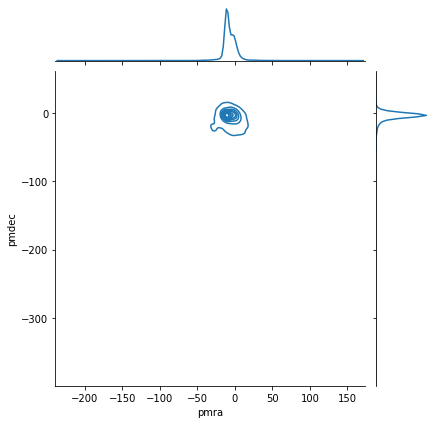

In [10]:
sns.jointplot(
    data=newdf,
    x="pmra", y="pmdec",
    kind="kde"
);

In [63]:
# Filter on PMRA and PMDEC
newdf = newdf[abs(newdf['pmra']) < 20]
newdf = newdf[abs(newdf['pmdec']) < 20]
len(newdf)

2078

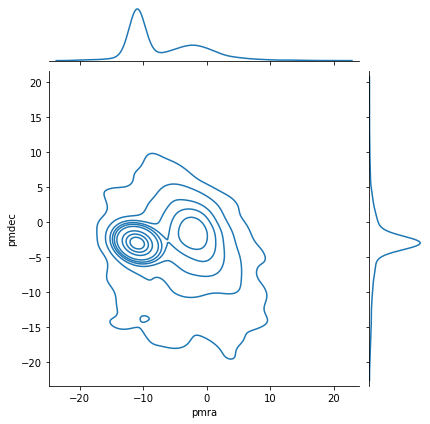

In [12]:
sns.jointplot(
    data=newdf,
    x="pmra", y="pmdec",
    kind="kde"
);

### Filterings

In [11]:
from scipy.optimize import curve_fit

# help(curve_fit)

In [12]:
from scipy.optimize import curve_fit

def fit_curve(data, column, bins = 100):
    
    plt.figure(figsize=(12,3), dpi=120)
    counts, bins, patches = plt.hist(data[column], bins = bins)

    # Define the Gaussian function
    def gaussian(x, amp, mu, sigma):
        return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))
    
    # data
    x_data = bins[:-1]
    y_data = counts
    
    # Fit the Gaussian function to the data
    popt, pcov = curve_fit(gaussian, x_data, y_data)
    
    plt.figure(figsize=(12,3), dpi=120)
    # Plot the original data and the fitted curve
    sns.scatterplot(x_data, y_data, label=column)
    plt.plot(x_data, gaussian(x_data, *popt), color='red', label='Fit')
    plt.legend()
    plt.show()
    
    return popt

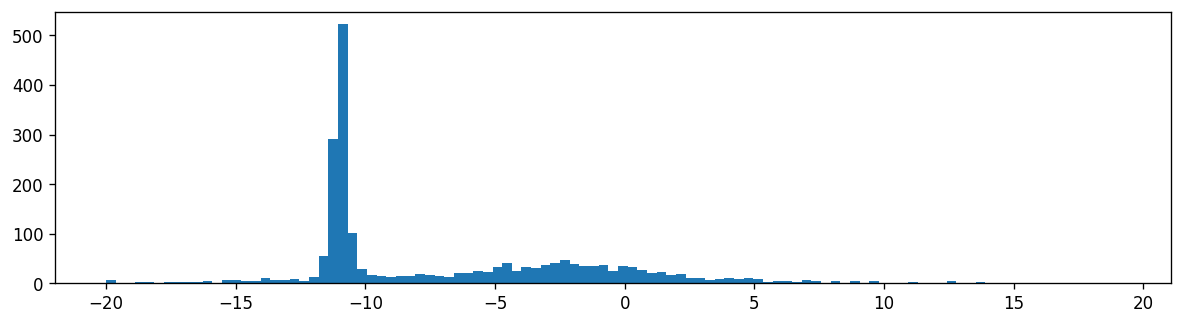

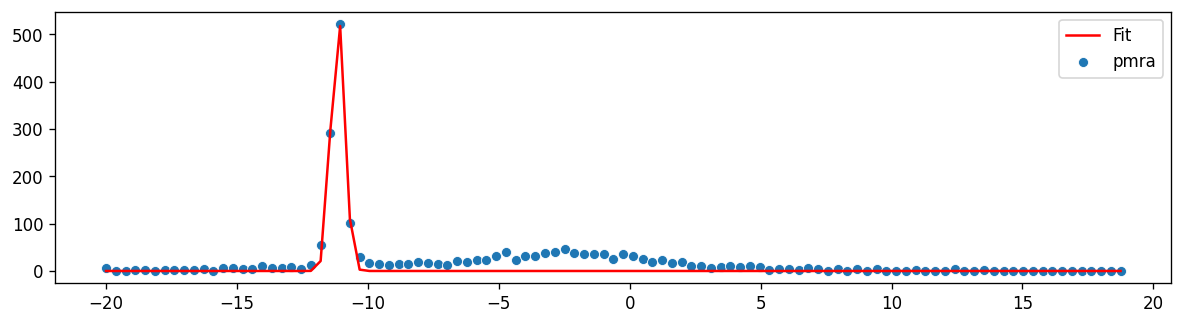

In [64]:
amp, mu, std = fit_curve(data=newdf, column='pmra', bins=105)

### filter on pmra

In [65]:
print(round(mu + 3 * std, 2), 
      round(mu - 3 * std, 2))

-10.38 -11.92


In [66]:
clusterdf = newdf[(newdf['pmra']< -10.38) & (newdf['pmra'] > -11.92)]
len(clusterdf)

966

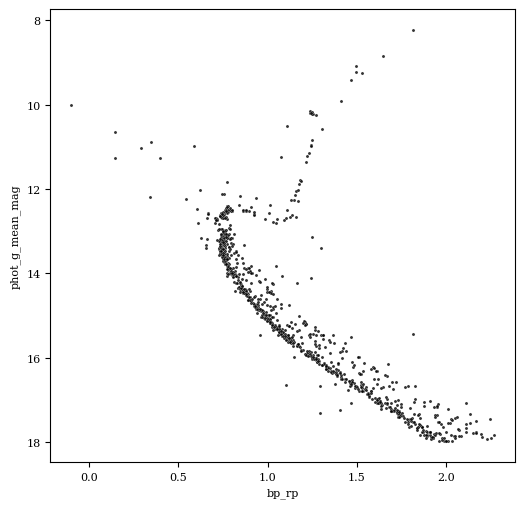

In [16]:
cmd_plot(clusterdf, 'bp_rp', 'phot_g_mean_mag')

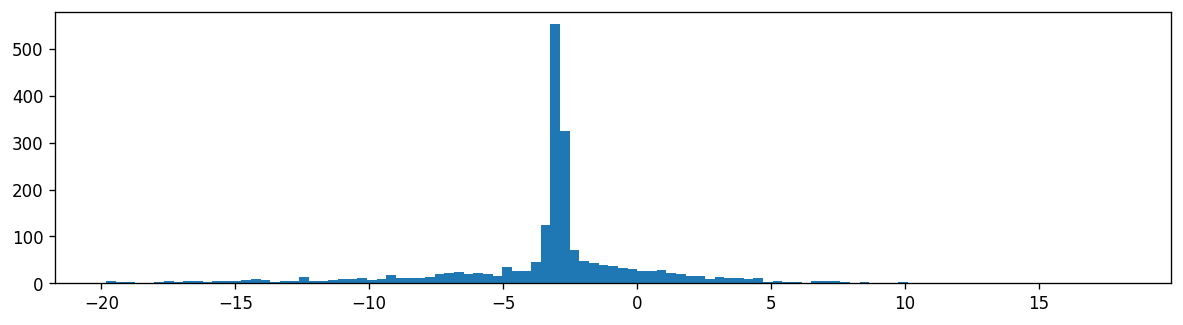

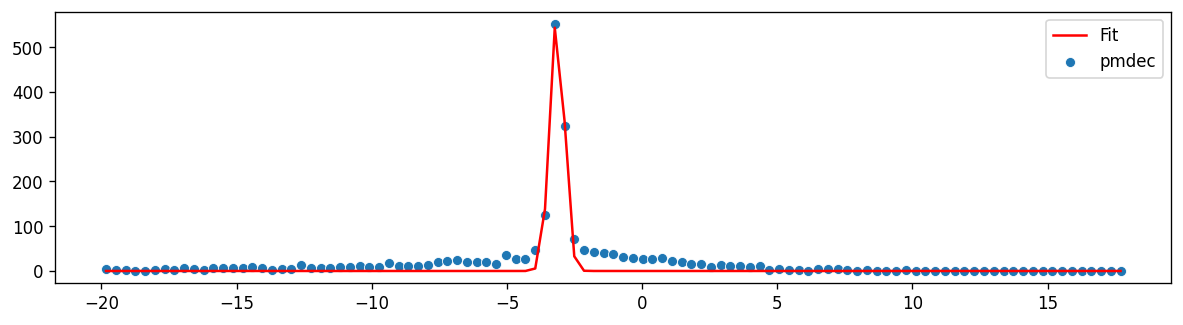

In [17]:
amp, mu, std = fit_curve(data=newdf, column='pmdec', bins=105)

### filter on pmdec

In [18]:
print(round(mu + 3 * std, 2), 
      round(mu - 3 * std, 2))

-3.94 -2.35


In [67]:
clusterdf = clusterdf[(clusterdf['pmdec'] < -2.35) & (clusterdf['pmdec'] > -3.95)]
len(clusterdf)

911

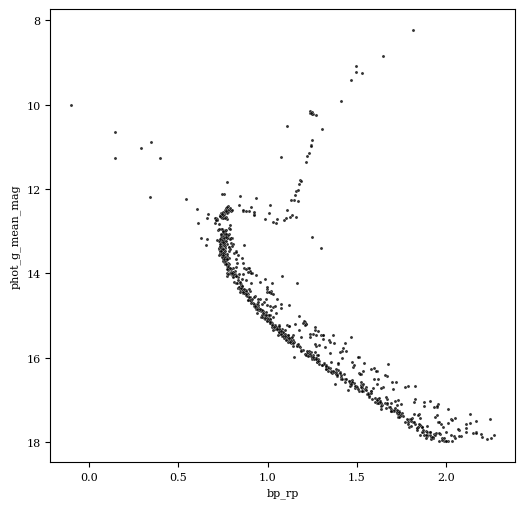

In [20]:
cmd_plot(clusterdf, 'bp_rp', 'phot_g_mean_mag')

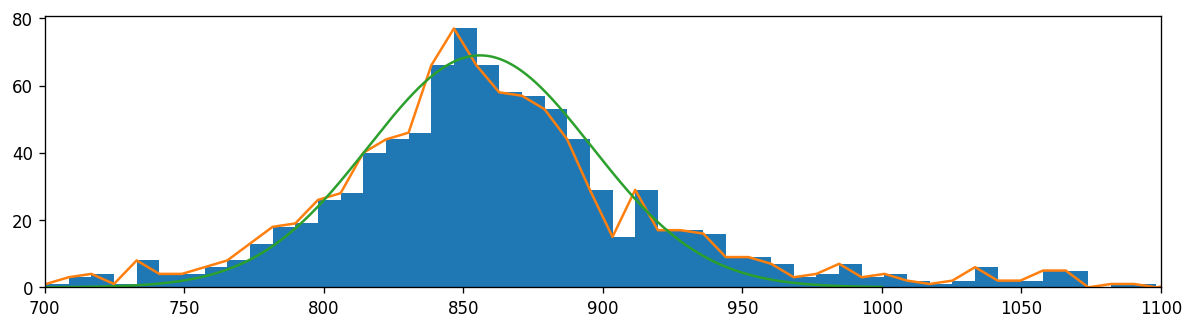

In [21]:
### fit dasti!!!

from astropy import modeling

plt.figure(figsize=(12,3), dpi=120)
counts, bins, patches = plt.hist(clusterdf['r_est'], bins = 110)

m = modeling.models.Gaussian1D(amplitude=69, mean=856, stddev=40)
x = np.linspace(700, 1000, 2000)
data = m(x)

plt.plot(bins[:-1], counts)
plt.xlim(700, 1100)
plt.plot(x, data);

### filter on r_est

In [22]:
clusterdf['r_est'].mean()

866.8166875105638

In [23]:
print(855 + 3*40, 855 - 3*40)

975 735


In [68]:
clusterdf = clusterdf[(clusterdf['r_est'] < 980) & (clusterdf['r_est'] > 730)]
len(clusterdf)

838

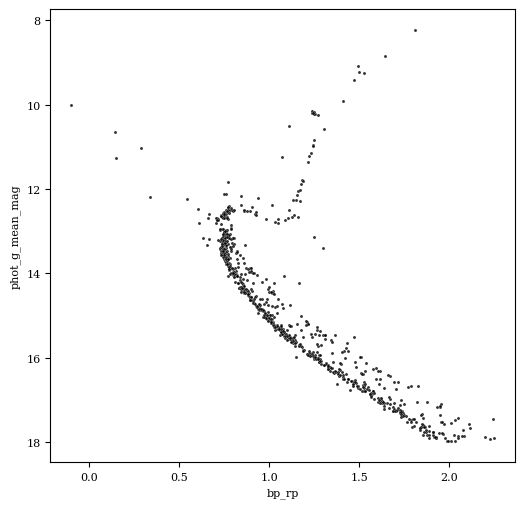

In [25]:
with plt.style.context(['ieee']):
    fig = plt.figure(figsize=(6,6), dpi=100)
    sns.scatterplot(data=clusterdf, y=clusterdf['phot_g_mean_mag'], x='bp_rp', alpha=0.8, s=5, )
    plt.gca().invert_yaxis()

## Luminosity of cluster

In [26]:
cluster_3d = clusterdf[['ra', 'dec', 'r_est']]

### Finding furthest stars from centroid

In [27]:
# cluster centroid
np.mean(cluster_3d)

ra       132.846232
dec       11.820787
r_est    857.413733
dtype: float64

In [28]:
# furthest cluster stars candidates using min
cluster_3d.loc[cluster_3d.idxmin()]

,ra,dec,r_est
2486,132.349114,11.910216,831.960949
41,132.794558,11.317111,863.910548
3045,132.412092,11.877839,734.177739


In [29]:
# furthest cluster stars candidates using max
cluster_3d.loc[cluster_3d.idxmax()]

,ra,dec,r_est
1225,133.333805,11.720945,954.664526
4610,132.833696,12.302884,858.241067
1755,132.810045,12.135904,979.492584


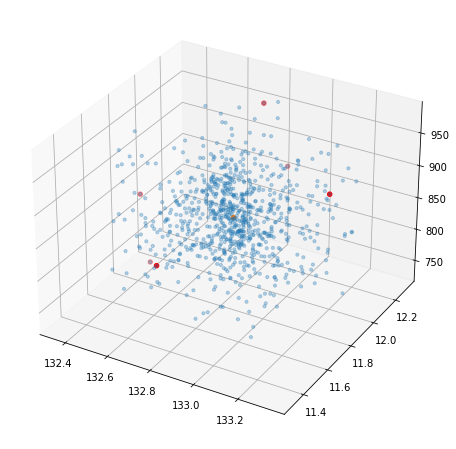

In [30]:
# %matplotlib qt
# %matplotlib notebook
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(cluster_3d['ra'], cluster_3d['dec'], cluster_3d['r_est'], s=10, alpha=0.3)
ax.scatter(np.mean(cluster_3d)['ra'], np.mean(cluster_3d)['dec'], np.mean(cluster_3d)['r_est'])
ax.scatter(cluster_3d.loc[cluster_3d.idxmax()]['ra'],
           cluster_3d.loc[cluster_3d.idxmax()]['dec'],
           cluster_3d.loc[cluster_3d.idxmax()]['r_est'], color='red')
ax.scatter(cluster_3d.loc[cluster_3d.idxmin()]['ra'],
           cluster_3d.loc[cluster_3d.idxmin()]['dec'],
           cluster_3d.loc[cluster_3d.idxmin()]['r_est'], color='red')
plt.show()

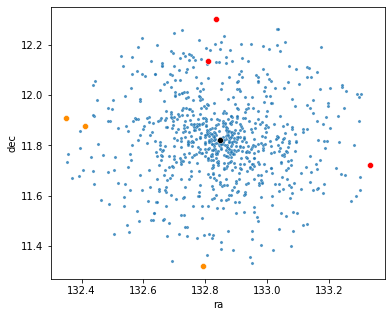

In [31]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data = cluster_3d, x = 'ra', y='dec', alpha=0.8, s=10)
sns.scatterplot(data = cluster_3d.loc[cluster_3d.idxmax()], x = 'ra', y='dec', color='red')
sns.scatterplot(data = cluster_3d.loc[cluster_3d.idxmin()], x = 'ra', y='dec', color='darkorange')
sns.scatterplot(x = [132.848648], y= [11.819672], color='black');

In [32]:
print('3D distances:',*distance.cdist([np.mean(cluster_3d)], cluster_3d.loc[cluster_3d.idxmax()]))
print('2D distances:',*distance.cdist([np.mean(cluster_3d)[:2]], cluster_3d.loc[cluster_3d.idxmax()][['ra', 'dec']]))

3D distances: [ 97.25206639   0.95763055 122.07926363]
2D distances: [0.49769022 0.48226048 0.31718866]


In [33]:
print('3D distances:',*distance.cdist([np.mean(cluster_3d)], cluster_3d.loc[cluster_3d.idxmin()]))
print('2D distances:',*distance.cdist([np.mean(cluster_3d)[:2]], cluster_3d.loc[cluster_3d.idxmin()][['ra', 'dec']]))

3D distances: [ 25.45779492   6.51651475 123.23677143]
2D distances: [0.50509841 0.50631909 0.4378731 ]


### Cluster Luminosity

#### cluster radius

In [34]:
c_radi = round(max(*distance.cdist([np.mean(cluster_3d)], cluster_3d.loc[cluster_3d.idxmin()])), 3)
c_radi

123.237

#### cluster average luminosity density (deg\*deg\*pc)

In [35]:
c_avg_lum_dens = np.sum(clusterdf['L']) / (4 * np.pi * (c_radi**3) / 3)
c_avg_lum_dens

0.00041444579050193756

### cluster luminosity density profile for each 6 NN

In [36]:
def luminosity_density(cluster_3d, clusterdf):
    """
    --------
    cluster_3d --> measuring distance in that dataframe
    
    clusterdf --> main dataframe
    -------
    """
    # create a NearestNeighbors object and fit the dataset
    nbrs = NearestNeighbors(n_neighbors=6, metric='minkowski').fit(cluster_3d)

    # find the 5 nearest neighbors for each data point including itself
    distances, indices = nbrs.kneighbors(cluster_3d)

    # find maximum distance among 5 neighbors
    max_distances = np.amax(distances, axis=1)

    # sphere of that max distance
    spheres = (4/3) * np.pi * (max_distances ** 3)

    # sum of luminosities of each 6 nn
    lum_sum = []
    for i in range(len(clusterdf)):
        lum_sum.append(np.sum(clusterdf.iloc[indices[i]]['L']))

    # luminosity density
    lum_dens = lum_sum / spheres

    return lum_dens

In [37]:
l_d = luminosity_density(cluster_3d, clusterdf)

In [38]:
print('max:', np.sort(l_d)[-1])
print('min:', np.sort(l_d)[0] )
print(np.mean(x))

max: 1437.8966348433682
min: 0.00013148910919737972
850.0


In [39]:
### plot for luminosity density profile

def lum_plot(data):
    with plt.style.context(['ieee']):
        plt.figure(figsize=(12,6), dpi=200)
        plt.plot(range(len(data)), np.sort(data))
        plt.ylabel('ΔL/ΔV')
        plt.title('luminosity density profile');

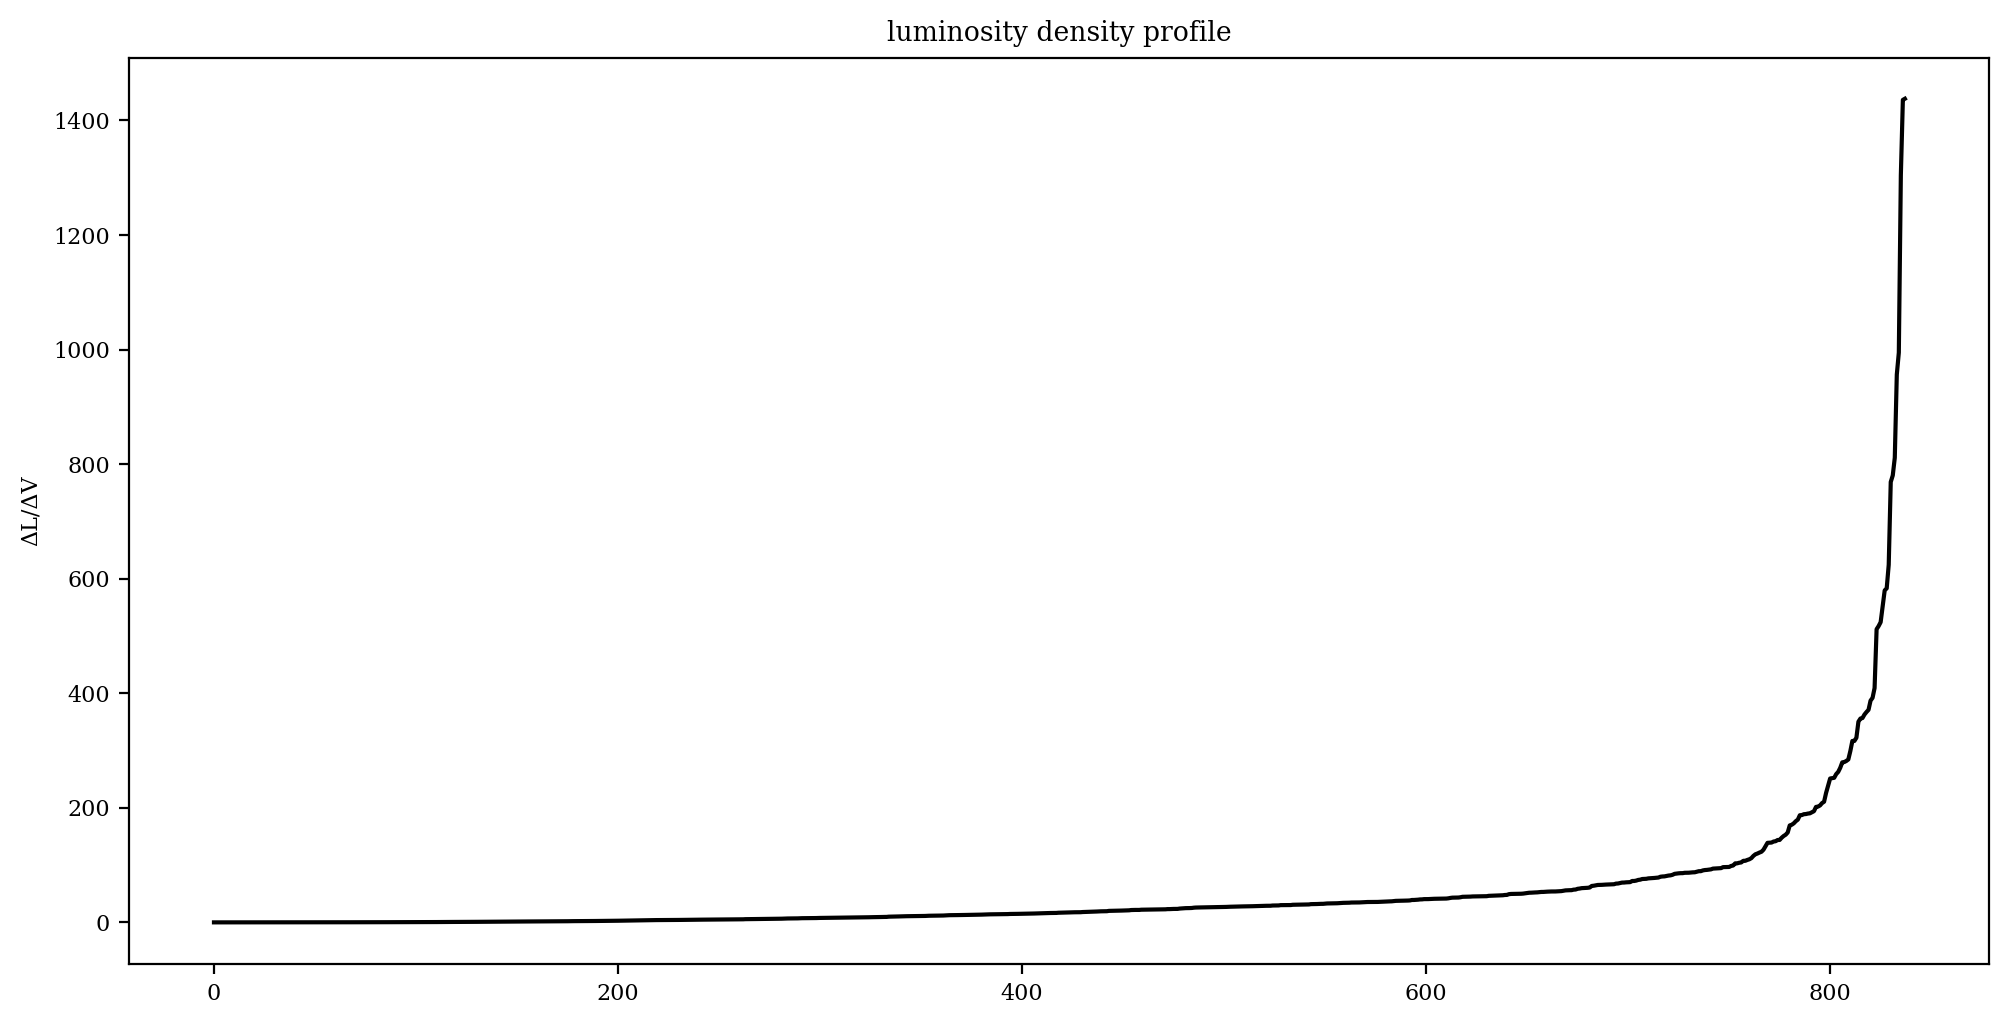

In [40]:
lum_plot(l_d)

In [41]:
# define a new dataset with parsec dimension for each value

x = np.sin(cluster_3d['ra'] * np.pi/180) * cluster_3d['r_est']
y = np.sin(cluster_3d['dec'] * np.pi/180) * cluster_3d['r_est']
z = cluster_3d['r_est']

cluster_pc = pd.DataFrame(data=np.column_stack([x, y, z]), columns=['x_ra', 'y_dec', 'z_est'])
cluster_pc.set_index(cluster_3d.index, inplace=True)
cluster_pc

,x_ra,y_dec,z_est
13,579.967559,155.981865,792.316386
33,599.176400,161.379639,817.818799
41,633.932717,169.532937,863.910548
67,614.757208,165.046585,839.903517
115,612.023498,166.252263,831.168141
...,...,...,...
5910,623.543250,172.789281,852.792952
5948,638.364179,176.368289,866.685893
5965,632.414167,177.611974,861.244781
5971,597.933473,165.613603,814.245910


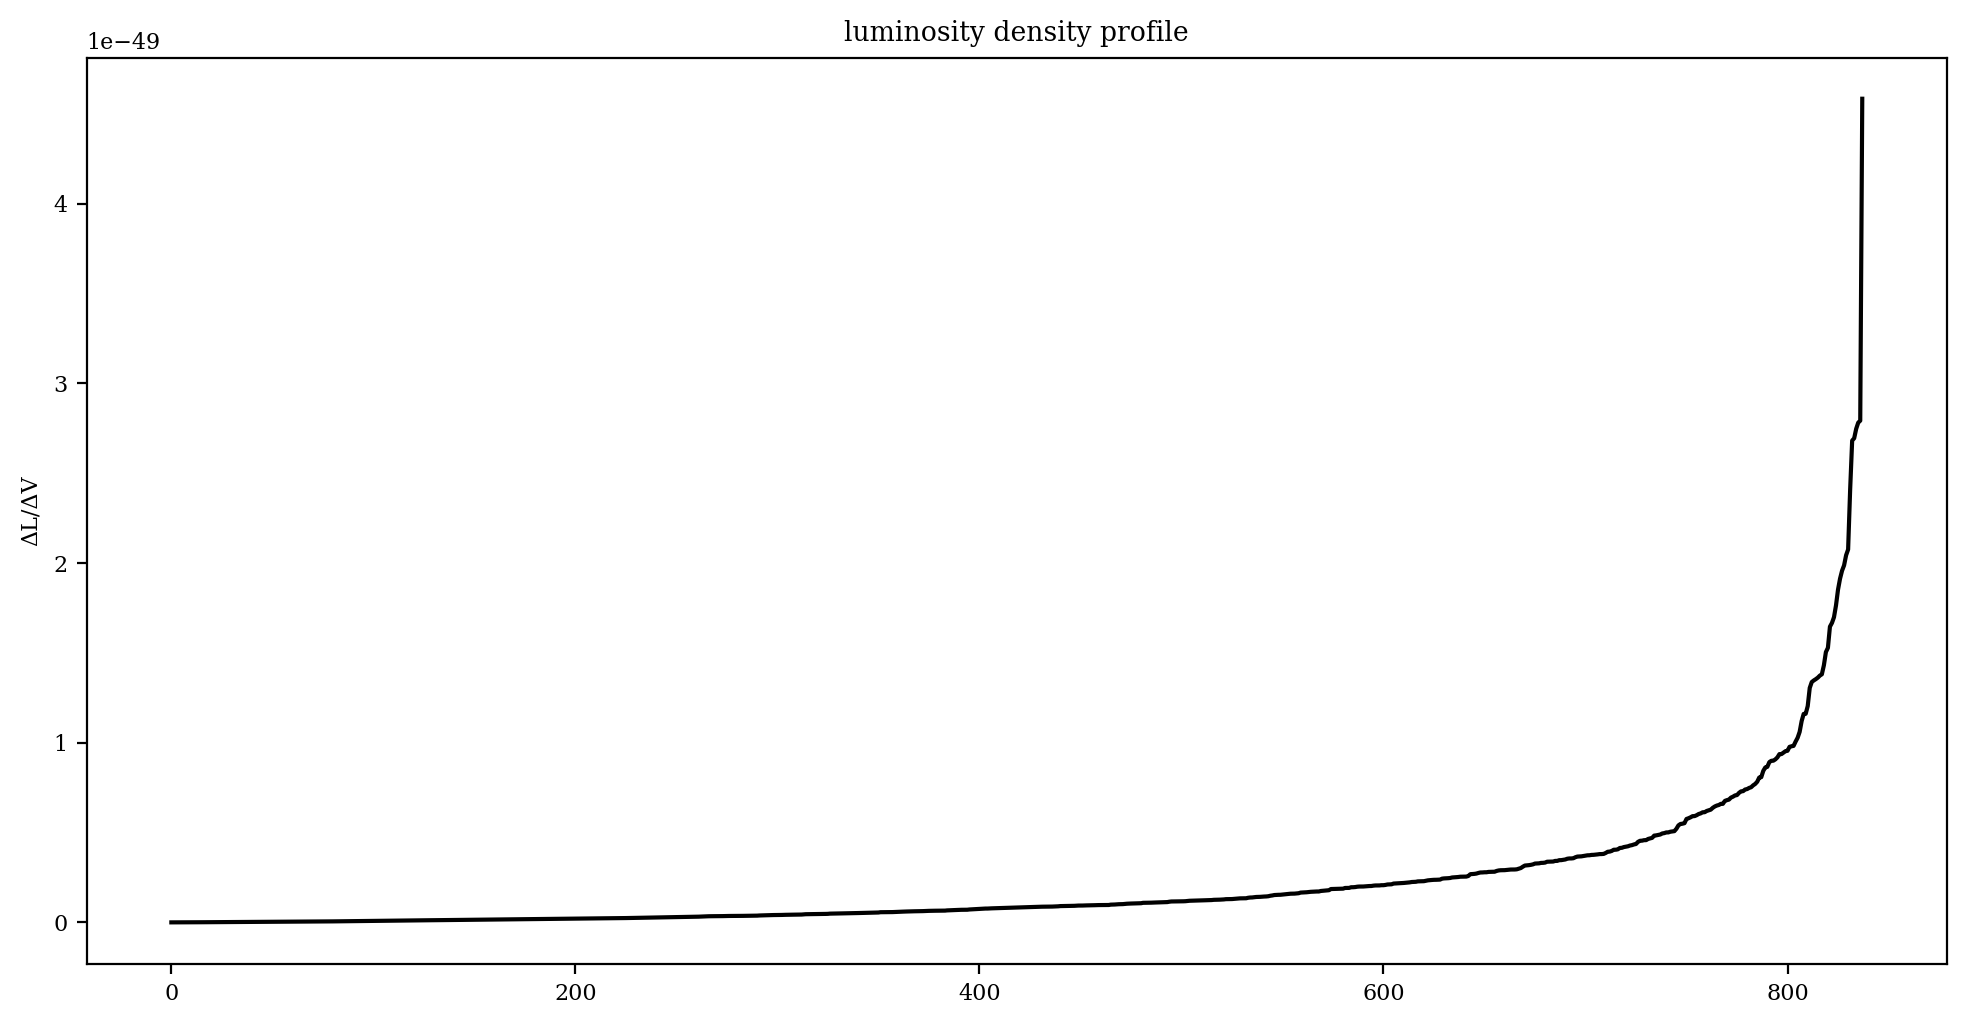

In [42]:
### 1 pc**3 == 2.938e+49 m**3

X = luminosity_density(cluster_pc, clusterdf) / 2.938e+49

lum_plot(X)

In [43]:
print( np.sort(X)[:5] )
print( np.sort(X)[-5:])

[1.70590732e-54 2.66430353e-54 4.49136834e-54 9.57542577e-54
 1.04392396e-53]
[2.69470988e-49 2.74758398e-49 2.78159331e-49 2.79268957e-49
 4.58465774e-49]


### Filter on luminosities under '1' for first density profile

In [44]:
# filter value is 1!
l = []
for i,j in enumerate(l_d):
    if j > 1:
        l.append([i,j])
l = np.array(l)
len(l)

705

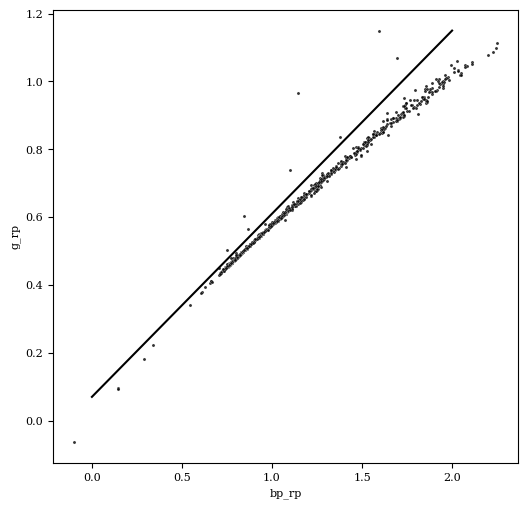

In [89]:
cmd_plot(clusterdf, 'bp_rp', 'g_rp')
plt.plot(np.linspace(0,2, 50), 0.54*np.linspace(0,2, 50) + 0.07)
plt.gca().invert_yaxis();

In [91]:
clusterdf[((clusterdf['bp_rp']*0.54)+0.07 ) < clusterdf['g_rp'] ]

,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,bp_rp,g_rp,r_est,Gmg,L
1782,132.832727,11.784245,1.035198,-11.137830,-2.652509,15.996343,1.146119,0.966078,938.442017,6.071459,0.318725
3328,132.850442,11.785929,1.119388,-10.901061,-2.867185,13.330969,0.866268,0.565259,870.722243,3.575872,3.174324
4283,133.046713,11.728836,1.299153,-10.968708,-2.834475,16.502298,1.593142,1.148354,754.098891,7.070599,0.126987
4487,132.806652,11.843910,1.091830,-11.235148,-2.705652,12.157651,0.845821,0.603183,891.803193,2.348427,9.831715
4605,132.850543,11.807408,1.174123,-10.909031,-3.224979,16.624977,1.377679,0.837226,831.005286,6.973546,0.138861
4859,132.877818,11.814579,1.333299,-10.595644,-2.950359,15.571340,1.100409,0.740097,734.407490,6.195977,0.284190
5329,133.089120,11.844945,1.101022,-11.235178,-2.890188,12.620180,0.750650,0.501728,884.660263,2.829159,6.314462
5726,132.821006,11.807434,1.261529,-11.043186,-3.121649,17.071190,1.693306,1.069384,775.551412,7.575675,0.079750


<AxesSubplot:xlabel='ra', ylabel='dec'>

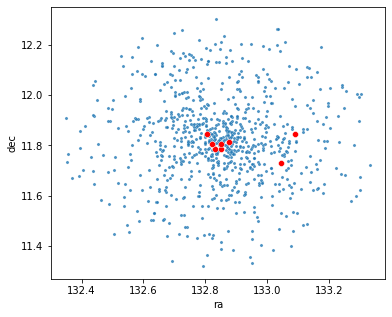

In [92]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data = clusterdf, x = 'ra', y='dec', alpha=0.8, s=10)
sns.scatterplot(data = clusterdf[((clusterdf['bp_rp']*0.54)+0.07 ) < clusterdf['g_rp'] ], x = 'ra', y='dec', color='red')

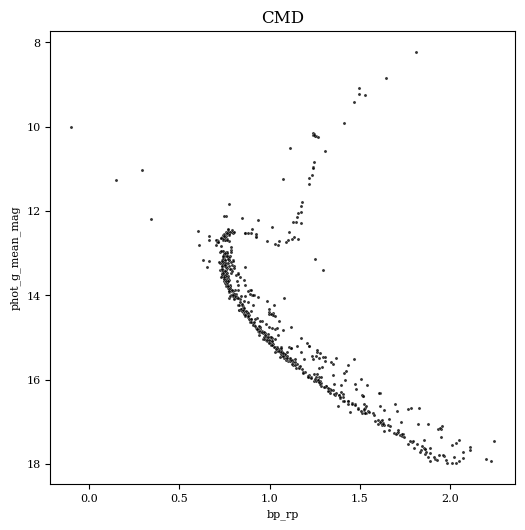

In [45]:
cmd_plot(clusterdf.iloc[l[:,0]], 'bp_rp', 'phot_g_mean_mag')
plt.title('CMD');

# M45

In [46]:
df_m45 = pd.read_csv('../data/M45-result.csv')

In [47]:
df_m45 = df_m45[df_m45['phot_g_mean_mag']<18]
df_m45 = df_m45[df_m45['parallax'] > 0]
len(df_m45)

24896

In [48]:
df_m45['Gmg'] = df_m45['phot_g_mean_mag'] + (5 * np.log10(df_m45['parallax']) - 10)
df_m45['L'] = 10**(0.4*(4.83 - df_m45['Gmg']))

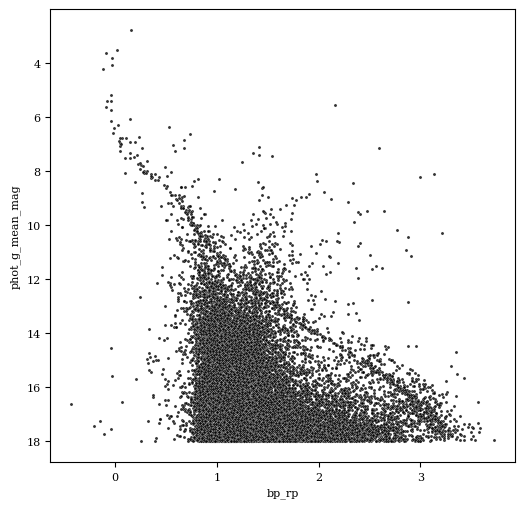

In [49]:
cmd_plot(df_m45, 'bp_rp', 'phot_g_mean_mag')

In [50]:
newdf = df_m45[['ra','dec','parallax','pmra','pmdec','bp_rp','r_est','phot_g_mean_mag', 'L']].dropna(axis=0)
newdf = newdf[abs(newdf['pmra']) < 15]
newdf = newdf[abs(newdf['pmdec']) < 15]
len(newdf)

21084

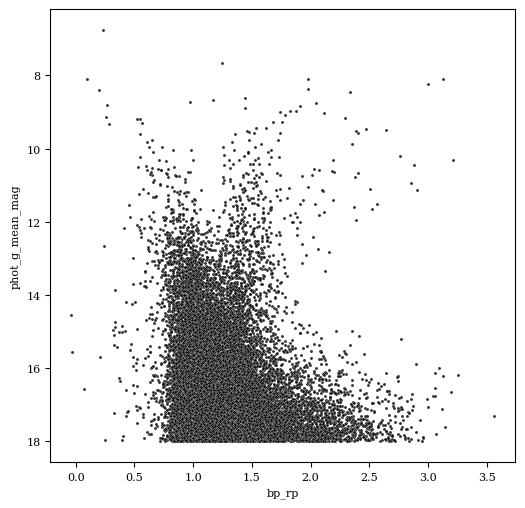

In [51]:
cmd_plot(newdf, 'bp_rp', 'phot_g_mean_mag')

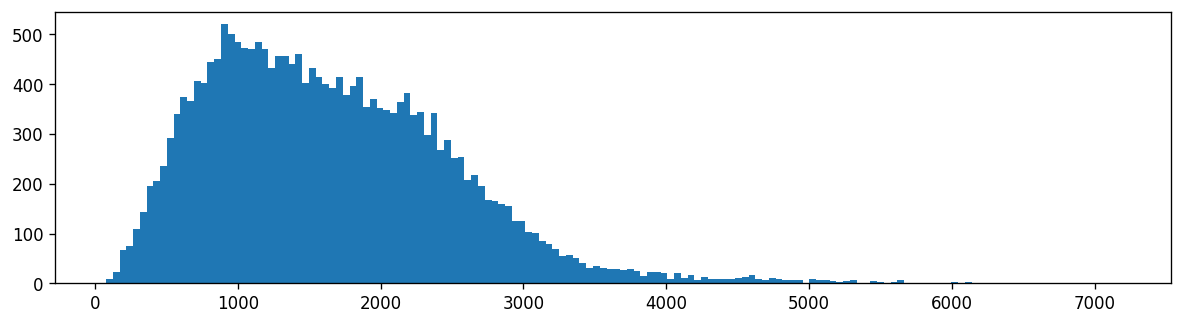

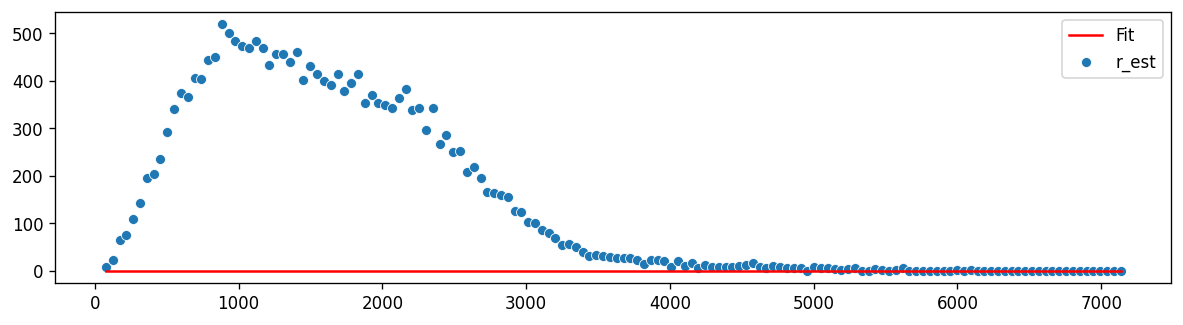

In [61]:
amp, mu, std = fit_curve(data=newdf, column='r_est', bins=150)

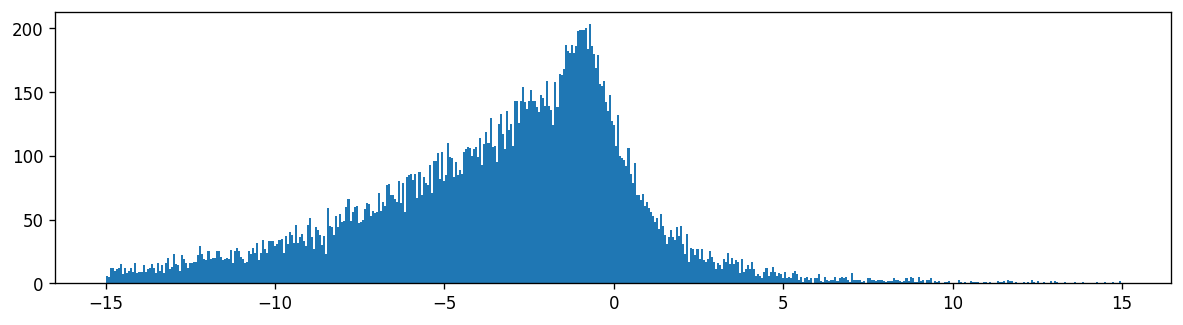

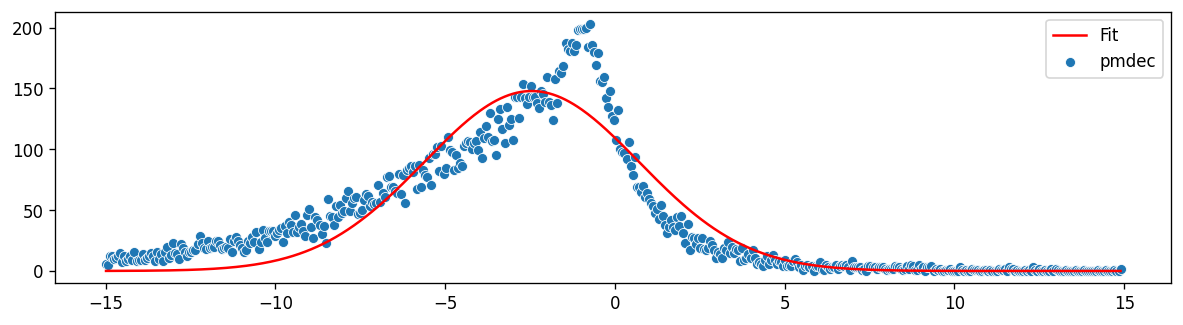

In [57]:
amp, mu, std = fit_curve(data=newdf, column='pmdec', bins=500)

In [58]:
plt.figure(figsize=(12,3), dpi=120)
counts, bins, patches = plt.hist(data[column], bins = bins)

# Define the Gaussian function
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

# data
x_data = bins[:-1]
y_data = counts

# Fit the Gaussian function to the data
popt, pcov = curve_fit(gaussian, x_data, y_data)

plt.figure(figsize=(12,3), dpi=120)
# Plot the original data and the fitted curve
sns.scatterplot(x_data, y_data, label=column)
plt.plot(x_data, gaussian(x_data, *popt), color='red', label='Fit')
plt.legend()
plt.show()

NameError: name 'column' is not defined

<Figure size 1440x360 with 0 Axes>

# M38

In [95]:
df = pd.read_csv('../data/M38-result.csv')

In [97]:
df = df[df['phot_g_mean_mag']<18]
df = df[df['parallax'] > 0]
len(df)

9151

In [98]:
df['Gmg'] = df['phot_g_mean_mag'] + (5 * np.log10(df['parallax']) - 10)
df['L'] = 10**(0.4*(4.83 - df['Gmg']))

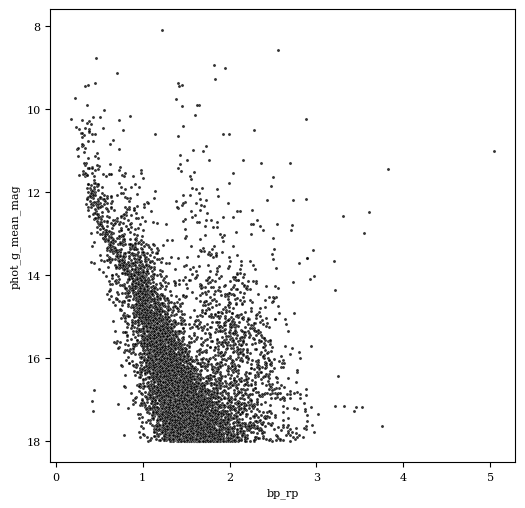

In [99]:
cmd_plot(df, 'bp_rp', 'phot_g_mean_mag')

In [172]:
newdf = df[['ra','dec','parallax','pmra','pmdec','bp_rp','r_est','phot_g_mean_mag', 'g_rp', 'L']].dropna(axis=0)
newdf = newdf[abs(newdf['pmra']) < 20]
newdf = newdf[abs(newdf['pmdec']) < 20]
len(newdf)

8954

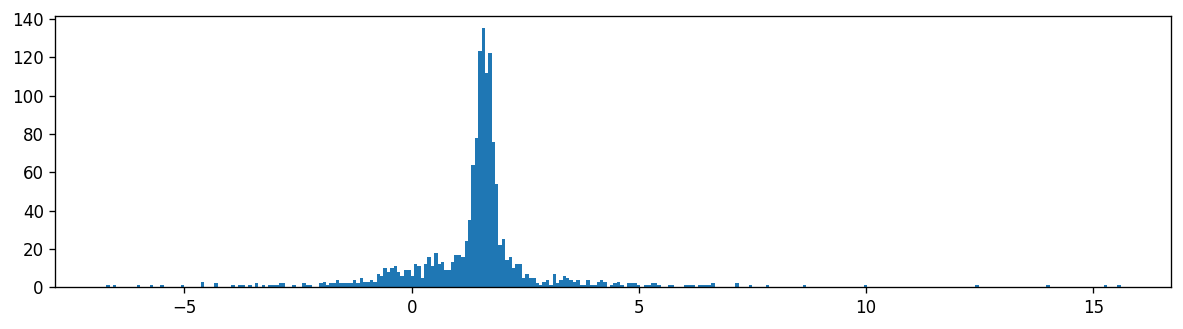

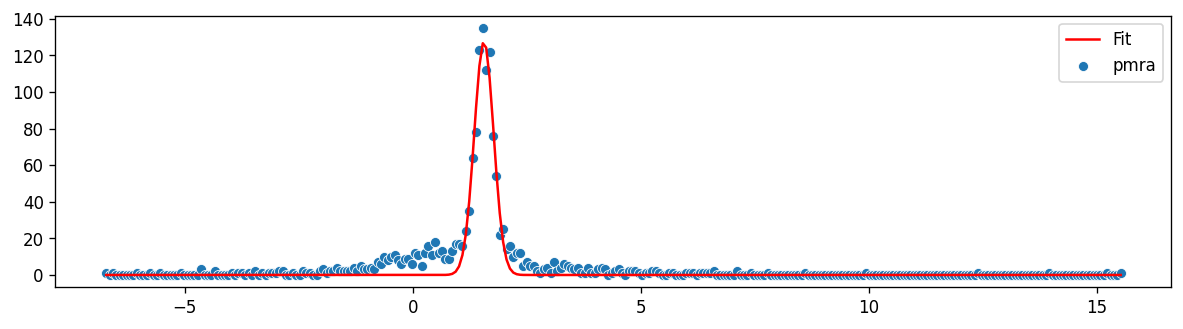

In [178]:
amp, mu, std = fit_curve(data=newdf, column='pmra', bins=300)

In [179]:
print(mu + 2*std)
print(mu - 2*std)

1.986830108922853
1.13626840003476


In [180]:
newdf = newdf[(newdf['pmra'] < 1.98) & (newdf['pmra'] > 1.13)]

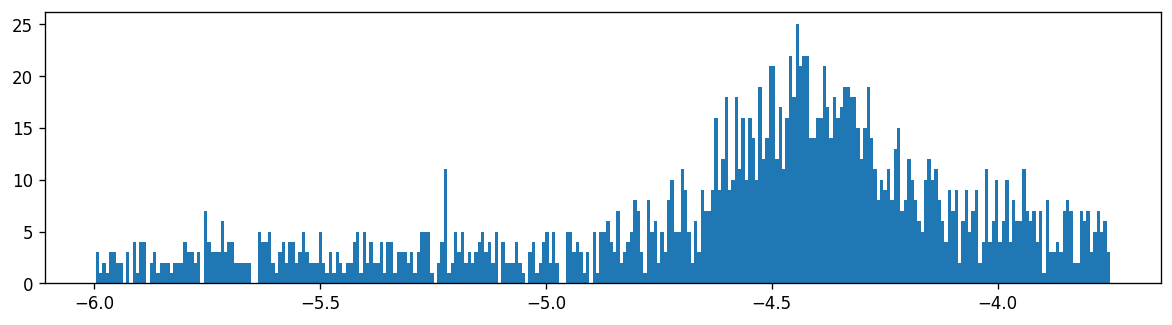

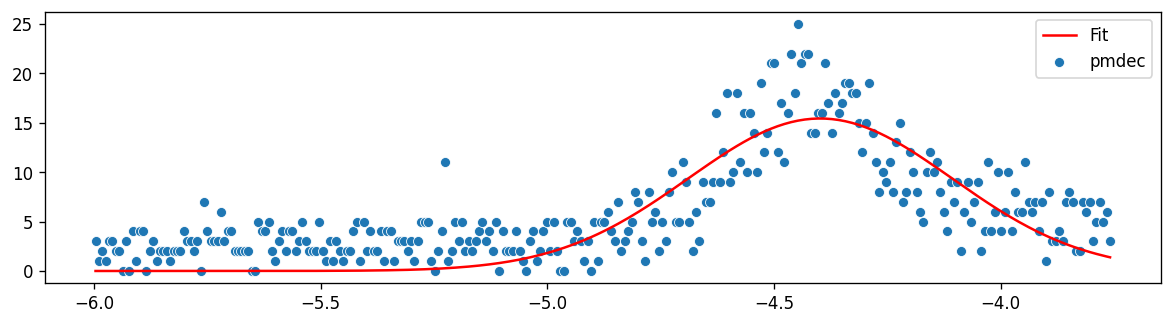

In [175]:
amp, mu, std = fit_curve(data=newdf, column='pmdec', bins=300)

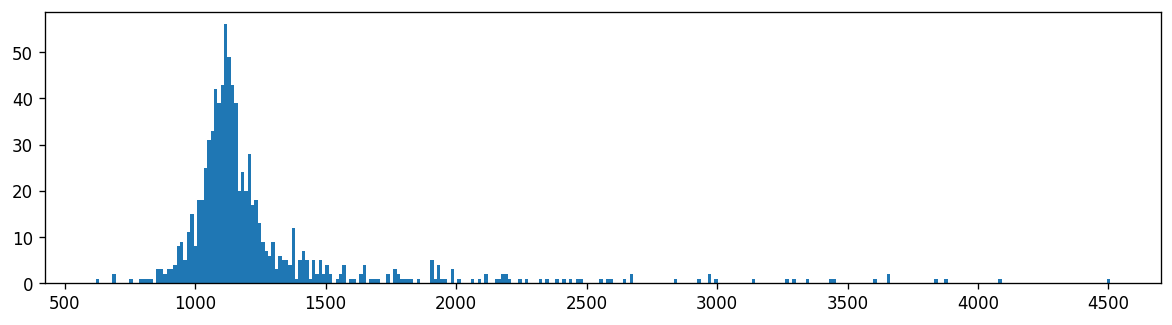

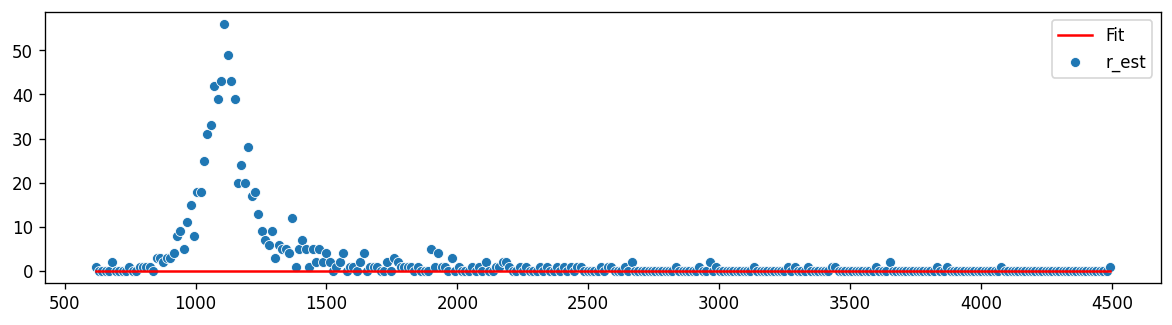

In [239]:
amp, mu, std = fit_curve(data=newdf, column='r_est', bins=300)

In [176]:
print(mu + 2*std)
print(mu - 2*std)

-3.8156891081529536
-4.980498047117594


In [177]:
newdf = newdf[(newdf['pmdec'] < -3.81) & (newdf['pmdec'] > -4.98)]

In [167]:
len(newdf)

853

In [174]:
newdf = newdf[(newdf['pmdec'] < -3.75) & (newdf['pmdec'] > -6)]

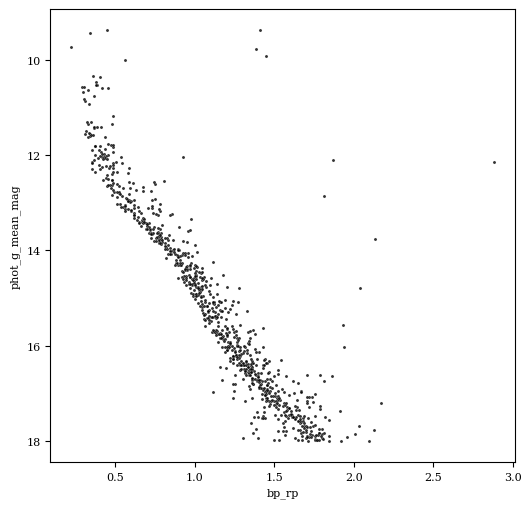

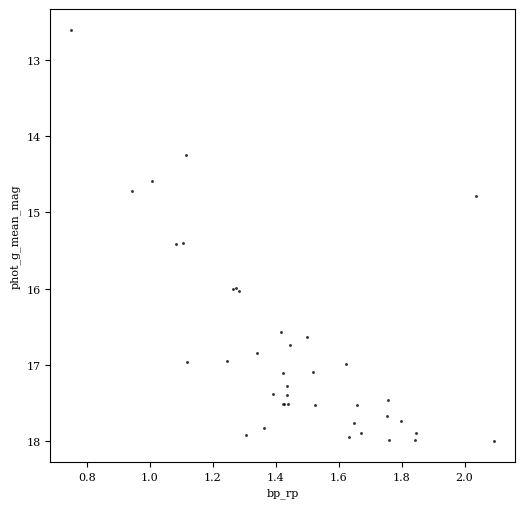

In [238]:
cmd_plot(newdf, 'bp_rp', 'phot_g_mean_mag')
cmd_plot(newdf[((newdf['bp_rp']*0.45)+0.171 ) < newdf['g_rp'] ], 'bp_rp', 'phot_g_mean_mag')

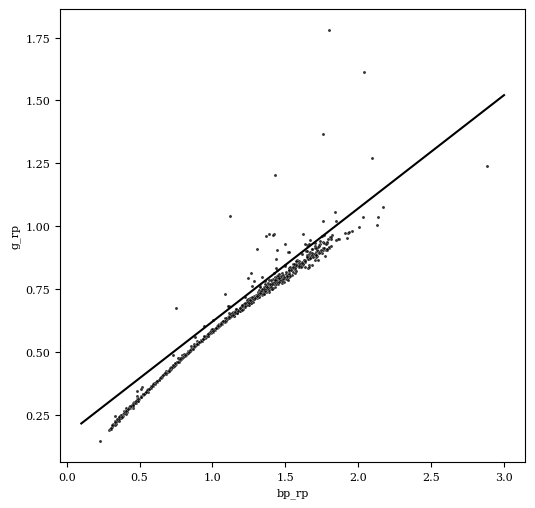

In [191]:
cmd_plot(newdf, 'bp_rp', 'g_rp')
plt.plot(np.linspace(0.1, 3), 0.45 * np.linspace(0.1, 3) + 0.171)
plt.gca().invert_yaxis();

In [237]:
newdf[((newdf['bp_rp']*0.45)+0.171 ) < newdf['g_rp'] ]

,ra,dec,parallax,pmra,pmdec,bp_rp,r_est,phot_g_mean_mag,g_rp,L
268,82.319661,35.669475,0.873351,1.323872,-4.596366,1.364254,1387.682073,17.828234,0.962191,0.082857
935,81.904455,35.416248,1.137067,1.664053,-4.226721,1.116370,858.552144,14.250962,0.682510,1.318388
1792,82.230957,35.387602,0.171022,1.440906,-4.229762,1.436289,3651.798465,17.392477,0.870831,3.227781
2920,82.150817,35.353986,0.803488,1.418370,-4.455316,1.445064,1213.939412,16.733706,0.826935,0.268261
4140,82.707608,35.912381,0.678677,1.882008,-4.307452,1.246292,1431.208859,16.944826,0.794519,0.309559
4379,82.428663,35.847350,0.860268,1.759820,-4.238482,1.424612,1175.368371,17.101578,0.815325,0.166764
8325,82.415023,35.758353,0.064046,1.185342,-4.533541,1.306776,3351.918195,17.920767,0.908564,14.148255
10685,82.437123,35.750163,0.840081,1.631335,-4.471006,1.341635,1184.982491,16.838722,0.796698,0.222776
11716,82.240262,35.638523,0.865391,1.802022,-4.741403,1.106114,1121.629138,15.399095,0.682364,0.790564
12869,82.310426,36.005226,0.598780,1.751715,-4.886550,1.671396,1681.410922,17.891163,0.944601,0.166341


<AxesSubplot:xlabel='ra', ylabel='dec'>

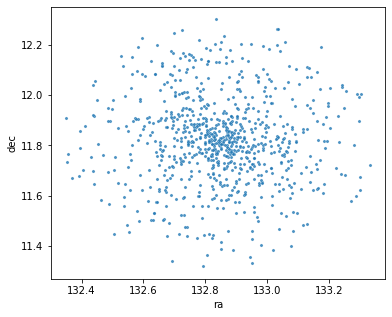

In [198]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data = clusterdf, x = 'ra', y='dec', alpha=0.8, s=10)
# sns.scatterplot(data = newdf[((newdf['bp_rp']*0.45)+0.171 ) < newdf['g_rp'] ], x = 'ra', y='dec', color='red')